In [1]:
import os
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

from FeatureAcquisition import FeatureAcquisition
from Predictor import Predictor
from Generators import GaussianSampler

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data", "Cube")

dataset_dict = torch.load(f"{DATA_DIR}/dataset_dict.pt")
X_train = torch.load(f"{DATA_DIR}/X_train.pt").float()
X_val   = torch.load(f"{DATA_DIR}/X_val.pt").float()
y_train = torch.load(f"{DATA_DIR}/y_train.pt").long()
y_val   = torch.load(f"{DATA_DIR}/y_val.pt").long()

In [3]:
# 하나의 샘플에서 k개가 관측되었다고 가정
# k개의 관측을 임의로 배정

def sample_mask_uniform_K_per_sample(bs: int, d: int, min_K: int = 1, max_K: int | None = None):
    if max_K is None: max_K = d
    m = np.zeros((bs, d), dtype=np.float32)
    Ks = np.random.randint(min_K, max_K+1, size=(bs,))
    for i, K in enumerate(Ks):
        idx = np.random.choice(d, size=K, replace=False)
        m[i, idx] = 1.0
    return m

In [4]:
feature_dim = 20 
num_classes = 8 
hidden_dim = 32 
predictor = Predictor(feature_dim, num_classes, hidden_dim)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
epochs = 10
lr = 1e-3
weight_decay = 1e-4

In [6]:
D = 20  # feature 개수 고정
predictor = predictor.to(device)
opt = AdamW(predictor.parameters(), lr=lr, weight_decay=weight_decay)
crit = nn.CrossEntropyLoss()

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

In [7]:
# ===== 학습 루프 =====
for ep in range(1, epochs + 1):
    predictor.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        m_np = sample_mask_uniform_K_per_sample(bs=xb.size(0), d=D, min_K=1, max_K=D)
        mb = torch.tensor(m_np, dtype=torch.float32, device=device)

        logits = predictor(xb, mb)
        loss = crit(logits, yb)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
        opt.step()

        total_loss += loss.item() * xb.size(0)

    # ===== 검증 =====
    predictor.eval()
    with torch.no_grad():
        xv, yv = X_val.to(device), y_val.to(device)
        mv = torch.zeros_like(xv)
        K_eval = D // 4  # 예: 10개 중 2~3개만 관측
        for i in range(xv.size(0)):
            idx = np.random.choice(D, size=K_eval, replace=False)
            mv[i, idx] = 1.0
        preds = predictor(xv, mv).argmax(dim=-1)
        acc = (preds == yv).float().mean().item()

    print(f"[Epoch {ep:02d}] TrainLoss={total_loss/len(X_train):.4f} | ValAcc={acc:.4f}")

[Epoch 01] TrainLoss=1.9798 | ValAcc=0.3591
[Epoch 02] TrainLoss=1.7837 | ValAcc=0.3989
[Epoch 03] TrainLoss=1.7376 | ValAcc=0.4195
[Epoch 04] TrainLoss=1.7215 | ValAcc=0.4239
[Epoch 05] TrainLoss=1.7144 | ValAcc=0.4323
[Epoch 06] TrainLoss=1.7113 | ValAcc=0.4386
[Epoch 07] TrainLoss=1.7067 | ValAcc=0.4343
[Epoch 08] TrainLoss=1.7022 | ValAcc=0.4306
[Epoch 09] TrainLoss=1.6982 | ValAcc=0.4315
[Epoch 10] TrainLoss=1.7022 | ValAcc=0.4392


In [8]:
X_test = torch.load(f"{DATA_DIR}/X_test.pt").float()
y_test = torch.load(f"{DATA_DIR}/y_test.pt").long()

device = next(predictor.parameters()).device
predictor.eval()

Predictor(
  (fc1): Linear(in_features=40, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

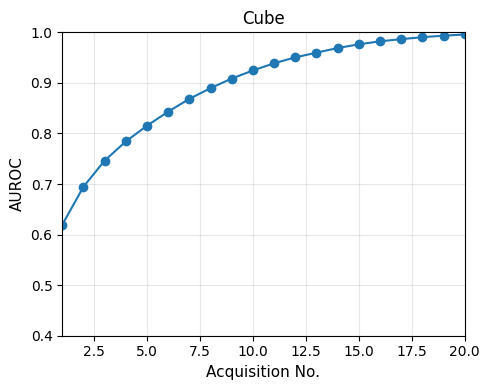

In [14]:
D = X_test.size(1)                 # 20
N = X_test.size(0)
x_np = X_test.cpu().numpy()
m_np = np.zeros((N, D), dtype=np.float32)   # 처음엔 아무 것도 관측 X

# 제너레이터는 기존과 동일하게 사용
generator = GaussianSampler(mean=0.0, std=1.0)

aurocs = []
steps  = list(range(1, D+1))

for t in steps:
    # 1) 한 스텝 획득 (마스크 1개 늘리기)
    FA = FeatureAcquisition(
        x=x_np,
        m=m_np,
        generative_model=generator,
        num_samples=10,
        predictor=predictor,
        alpha=1.0,
        gamma=1.0
    )
    m_np, selected = FA.acquire()  # m_np 업데이트됨

    # 2) 현재 마스크로 테스트 AUROC 측정
    with torch.no_grad():
        xv = X_test.to(device)
        mv = torch.tensor(m_np, dtype=torch.float32, device=device)
        logits = predictor(xv, mv)                     # predictor가 로짓이면 그대로
        probs  = F.softmax(logits, dim=-1).cpu().numpy()

    # 멀티클래스 macro-OVR AUROC
    y_true = y_test.cpu().numpy()
    try:
        auc = roc_auc_score(y_true, probs, multi_class='ovr', average='macro')
    except ValueError:
        # 클래스가 하나만 나오는 등 특이 케이스 방어
        auc = np.nan
    aurocs.append(auc)

# ===== 시각화 =====
plt.figure(figsize=(5,4))                # 그림 크기 비슷하게
plt.plot(steps, aurocs, marker='o')
plt.xlabel('Acquisition No.', fontsize=11)
plt.ylabel('AUROC', fontsize=11)
plt.title('Cube', fontsize=12)
plt.xlim(1, 20)
plt.ylim(0.4, 1.0)
plt.grid(True, alpha=0.3)

# inset (확대 영역)
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# ax = plt.gca()
# axins = inset_axes(ax, width="50%", height="50%", loc='center right')

# axins.plot(steps, aurocs, marker='o')
# axins.set_xlim(6, 20)
# axins.set_ylim(0.96, 0.986)
# axins.grid(True, alpha=0.3)
# axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()